# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [72]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd




In [73]:
pip install pandas requests lxml


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [74]:

url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify" # convertir la URL en una variable
headers = {"User-Agent": "Mozilla/5.0"} # esto se hace para parecer un navegador real y evitar bloqueos
response = requests.get(url, headers=headers) # contiene toda la respuesta del servidor a tu petición HTTP en un formato de objeto
print(response.status_code) #es una forma de verificar que la petición fue exitosa (200)
response.raise_for_status() # detiene el programa si hubo un error
html = response.text # # convierte la respuesta en texto HTML en string

200


In [75]:
# convertimos el html en una sopa
soup = BeautifulSoup(html, "lxml") # lo convertimos a sopa para poder recorrerlo más fácilmente.
# Usamos lxml como una buena practica porque hay paginas que no se pueden parsear(recorrer) bien con el parser por defecto de python
table = soup.find("table", {"class": "wikitable"}) # creamos una variable y buscamos en la pagina por su clase CSS la tabla con la que queremos trabajar, esto te devuelve un objeto.

df = pd.read_html(str(table))[0] # Convertimos la tabla a DataFrame de pandas
print("Tabla cargada. Primeras 5 filas:")
print(df.head())


Tabla cargada. Primeras 5 filas:
  Rank                 Song                 Artist(s) Streams (billions)  \
0    1    "Blinding Lights"                The Weeknd              5.086   
1    2       "Shape of You"                Ed Sheeran              4.603   
2    3            "Starboy"  The Weeknd and Daft Punk              4.155   
3    4    "Sweater Weather"         The Neighbourhood              4.105   
4    5  "Someone You Loved"             Lewis Capaldi              4.095   

        Release date Ref.  
0   29 November 2019  [1]  
1     6 January 2017  [2]  
2  21 September 2016  [3]  
3    3 December 2012  [4]  
4    8 November 2018  [5]  


/tmp/ipykernel_816/3281980235.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0] # Convertimos la tabla a DataFrame de pandas


In [76]:
# Inspeccionamos el DataFrame
print("\nInformación del DataFrame:")
print(df.info())

print("\ndescripción estadística:")
print(df.describe())

print("\nnombres de columnas:") # esto es útil para saber si hay espacios o caracteres especiales en los nombres de las columnas
print(df.columns.tolist()) # el toList() es solo para convertir el resultado en una lista más legible. 
# Puedo mirar los nombres de las columnas también con solo df.columns



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Rank                101 non-null    object
 1   Song                101 non-null    object
 2   Artist(s)           101 non-null    object
 3   Streams (billions)  101 non-null    object
 4   Release date        101 non-null    object
 5   Ref.                98 non-null     object
dtypes: object(6)
memory usage: 4.9+ KB
None

descripción estadística:
       Rank               Song   Artist(s) Streams (billions)  Release date  \
count   101                101         101                101           101   
unique  101                101          78                 94           100   
top       1  "Blinding Lights"  The Weeknd              3.145  20 June 2014   
freq      1                  1           4                  2             2   

       Ref.  
cou

In [77]:
# Generamos una copia del DataFrame original
df_clean = df.copy()
# Eliminamos filas con valores vacios por buena practica en limpieza de datos,
# ya que en este caso no hay filas completamente vacias
df_clean.dropna(how = 'all', inplace=True)
# Normalizamos nombres de columnas: quitar espacios al principio/final, reemplazar espacios por underscore 
# y poner todo en minúsculas
df_clean.columns = [col.strip().lower().replace(" ", "_") for col in df_clean.columns] 
# strip() quita espacios al principio y final, 
# lower() pone todo en minúsculas, replace() reemplaza espacios por underscores
print("\nNombres de columnas después de la limpieza:")
print(df_clean.columns.tolist())
print("\nInformación del DataFrame limpio:")
print(df_clean.info())




Nombres de columnas después de la limpieza:
['rank', 'song', 'artist(s)', 'streams_(billions)', 'release_date', 'ref.']

Información del DataFrame limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   rank                101 non-null    object
 1   song                101 non-null    object
 2   artist(s)           101 non-null    object
 3   streams_(billions)  101 non-null    object
 4   release_date        101 non-null    object
 5   ref.                98 non-null     object
dtypes: object(6)
memory usage: 4.9+ KB
None


In [78]:
# Limpiamos datos en columnas específicas
df_clean["song"] = df_clean["song"].str.lower().replace(r"\[.*?\]", "", regex=True)
df_clean["artist(s)"] = df_clean["artist(s)"].str.lower().replace(r"\[.*?\]", "", regex=True)

df_clean = df_clean[df_clean["streams_(billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)]
# Convertimos Streams a números flotantes
df_clean["streams_(billions)"] = df_clean["streams_(billions)"].astype(float)

# Convertimos fechas a datetime
df_clean["release_date"] = pd.to_datetime(df_clean["release_date"], errors="coerce")

print("\nInformación del DataFrame limpio:")
print(df_clean.info())
print("\nPrimeras 5 filas del DataFrame limpio:")
print(df_clean.head())





Información del DataFrame limpio:
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rank                100 non-null    object        
 1   song                100 non-null    object        
 2   artist(s)           100 non-null    object        
 3   streams_(billions)  100 non-null    float64       
 4   release_date        100 non-null    datetime64[ns]
 5   ref.                97 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 5.5+ KB
None

Primeras 5 filas del DataFrame limpio:
  rank                 song                 artist(s)  streams_(billions)  \
0    1    "blinding lights"                the weeknd               5.086   
1    2       "shape of you"                ed sheeran               4.603   
2    3            "starboy"  the weeknd and daft punk               4.15

In [79]:
conn = sqlite3.connect("Spotify.db")
df_clean.to_sql("Mas Escuchados", conn, if_exists="replace", index=False)
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM 'Mas Escuchados'")
print("Encontradas:", cursor.fetchone()[0])

conn.commit()
conn.close()

Encontradas: 100


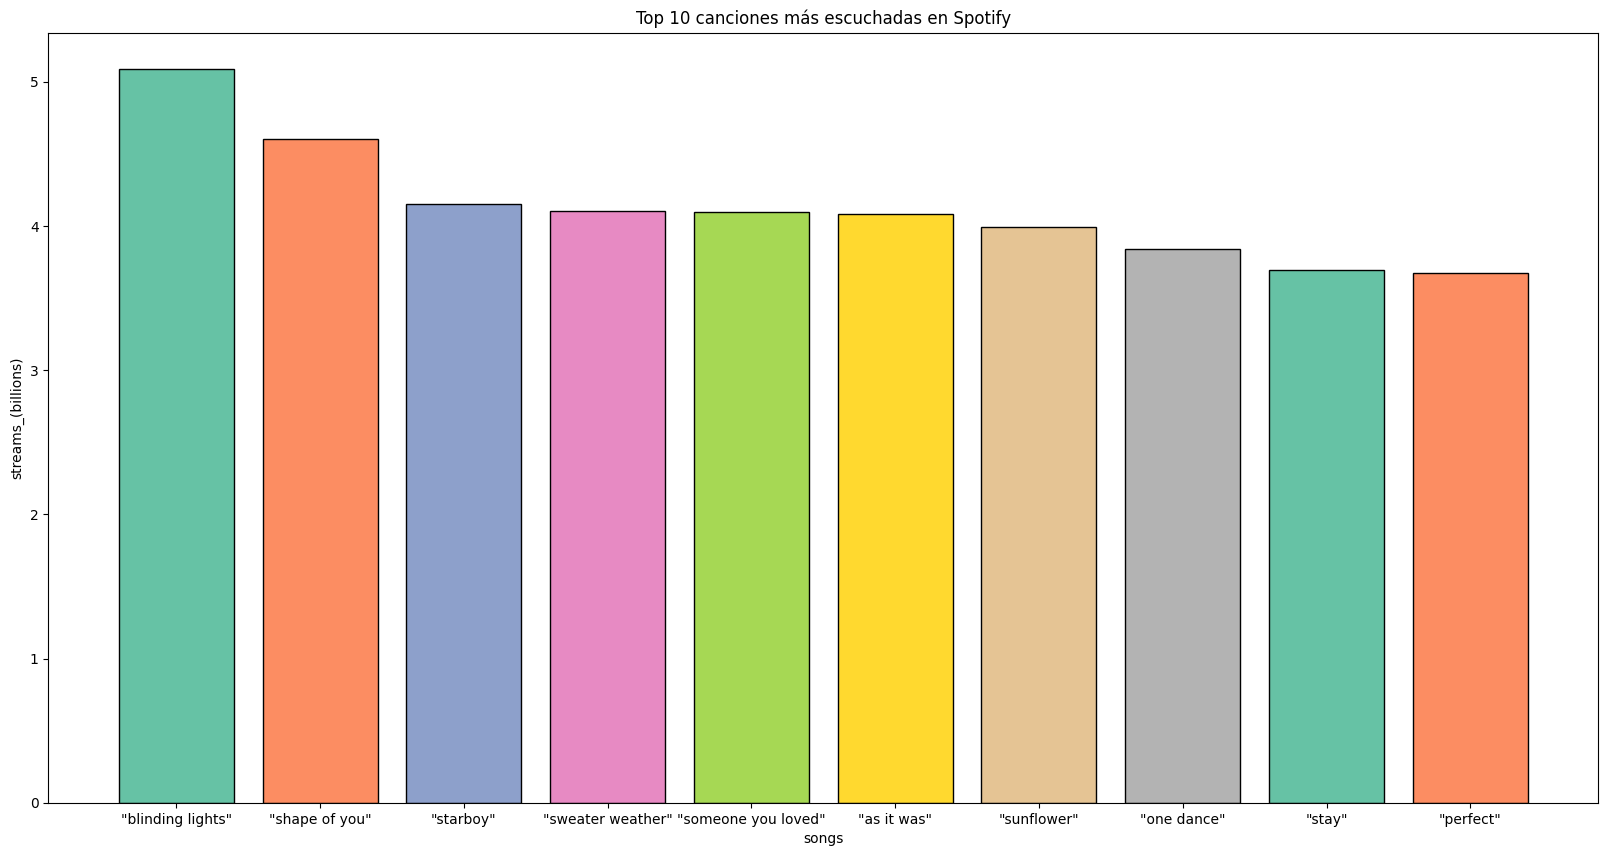

In [ ]:
# GRAFICO DE BARRAS
fig, ax = plt.subplots(figsize=(20, 10))
y = df_clean["streams_(billions)"].head(10)
x = df_clean["song"].head(10)
palette = sns.color_palette('Set2', n_colors=len(x))
ax.bar(x, y, color=palette, edgecolor='black')
ax.set_title('Top 10 canciones más escuchadas en Spotify')
ax.set_xlabel('songs')
ax.set_ylabel('streams_(billions)')
plt.show()

# PERDON POR LA PALETA DE COLORES 😂